- load model #16
- explainer = shap.KernelExplainer(model, X_train)
- get shap_values = explainer.shap_values(X_test_shap)
- save shap_values_16_n_samples.npy\
=> shap values for 212 features! 128 svd components + 84 handselected genes
- same steps for model #17

In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables
# necessary for pd.read_hdf()
!pip install shap

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
# !pip install catboost
!pip install shap
!pip install anndata

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import shap

import anndata as ad

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

## data load

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'
private_data_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

# multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
# multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
# multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
# multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite  (code from codebase, same steps as in run_model.ipynb)

In [5]:
# short names of models used in ensemble
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [6]:
# create model_name_list containing the actual file name of each model from mlp_model_name
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [7]:
# list of file names: test sets that correspond to each model in model_name_list
# weights used for weighting model predictions in ensemble
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

# create dict of shape {model_name: [test set, weight]}
model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model (from codebase)

Only need to load the model, not run the predictions as they are in run_model.ipynb

In [8]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [9]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [10]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [11]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [12]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### model #16

In [13]:
# only need model, not whole prediction

# model #16: cite_mlp_corr_svd_128_flg_donor_val_30

model_name = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model16 = CiteModel_mish(feature_dims)
else:
    model16 = CiteModel(feature_dims)
    
model16 = model16.to(device)
model16.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [14]:
# X_train for model #16: 'X_svd_128.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

# explainer16 = shap.KernelExplainer(model16, shap.sample(X_train, 1000))

med = X_train.median().values.reshape((1,X_train.shape[1]))
# explainer16 = shap.KernelExplainer(model16, med)

# zeros = np.zeros((1,212), dtype=float)
explainer16 = shap.KernelExplainer(model16, med)

X_train:  (70988, 212)
X_test:  (48203, 212)


In [15]:
X_test_shap = ad.read_h5ad('X_test_shap_16_50_samples.h5ad')

In [16]:
np.set_printoptions(suppress=True)
med[:,:15].round(2)

array([[87.35, -2.75, -2.78, -0.3 , -0.38, -0.92, -0.12, -0.59,  0.13,
        -0.51,  0.2 ,  0.12, -0.13, -0.13,  0.06]], dtype=float32)

In [17]:
# features: genes and svd -> omnipath: genes
# model: mostly relying on genes or svd? -> later

In [18]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer16.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_16_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [19]:
# shap_values[0]

### model #17

In [20]:
# only need model, not whole prediction
# model #17: cite_mlp_corr_svd_64_flg_donor_val_38

model_name = 'cite_mlp_corr_svd_64_flg_donor_val_38'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model17 = CiteModel_mish(feature_dims)
else:
    model17 = CiteModel(feature_dims)
    
model17 = model17.to(device)
model17.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

<All keys matched successfully>

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [21]:
# X_train for model #17: 'X_svd_64.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer17 = shap.KernelExplainer(model17, med)  #shap.sample(X_train, 1000))

X_train:  (70988, 148)
X_test:  (48203, 148)


In [22]:
X_test_shap = ad.read_h5ad('X_test_shap_17_50_samples.h5ad')

In [23]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer17.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_17_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [24]:
# shap_values[0]

### same steps for private test data

steps for model 16: compute shap values on 50 samples per cell type

In [25]:
X_train_p_sampled = ad.read_h5ad('private_train_input_max_samples.h5ad')  # 160 samples per cell type -> even distr.
X_train_p_sampled.obs

,kaggle_dataset,day,donor,cell_type,ID
"TACAGGTAGCAGGGAG-1-('31800', 2)",train,2,31800,BP,46924
"TTTCGATGTACCTATG-1-('31800', 2)",train,2,31800,BP,47398
"AACGGGAGTTGACTAC-1-('31800', 2)",train,2,31800,BP,53848
"ACTTCCGTCTGGCCGA-1-('13176', 2)",train,2,13176,BP,24550
"GGAGGATCACTGCACG-1-('13176', 4)",train,4,13176,BP,39974
...,...,...,...,...,...
"CCTAACCGTTAAGTCC-1-('31800', 4)",train,4,31800,NeuP,68712
"TCCGGGAAGATTAGCA-1-('31800', 4)",train,4,31800,NeuP,69027
"CATGCCTTCGTAGGAG-1-('31800', 3)",train,3,31800,NeuP,56509
"AGGGCTCTCGACCTAA-1-('31800', 3)",train,3,31800,NeuP,55779


In [26]:
X_train_p_16 = pd.read_pickle('private_X_train_svd_128.pkl')            # use full train set
X_train_p_16 = X_train_p_16.iloc[np.sort(X_train_p_sampled.obs['ID'])]     # use 160 samples per cell type -> even distr.

X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_50_samples.h5ad')

print('X_train: ', X_train_p_16.shape)
print('X_test: ', X_test_p_16.shape)

med = X_train_p_16.median().values.reshape((1,X_train_p_16.shape[1]))
explainer16_p = shap.KernelExplainer(model16, med.astype('float32'))

# shap_values_16_p = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

X_train:  (1120, 212)
X_test:  (350, 212)


In [27]:
# np.save('shap_values_16_50_samples_p_ct_distr.npy', np.array(shap_values_16_p, dtype=object), allow_pickle=True)

#### analyse SHAP properties on 5 samples per cell type

use data with svd components and handselected genes but only use handselected genes for comparison between models 16, 17, and ensemble.

In [28]:
X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_5_samples.h5ad')
X_test_p_16.to_df().median().values.reshape((1,X_train_p_16.shape[1]))[:,-84:]  # X_test column median of the handselected genes

array([[0.       , 0.       , 0.       , 1.8138117, 0.       , 0.       ,
        0.       , 2.1552792, 1.7742511, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 1.2818234,
        1.5404364, 1.6152524, 2.0646195, 0.       , 0.       , 1.8752995,
        0.       , 1.5618597, 0.       , 0.       , 1.7934363, 0.       ,
        0.       , 1.5125499, 0.       , 1.977549 , 0.       , 1.8843051,
        0.       , 2.1789148, 0.       , 1.9506857, 2.0815597, 1.9396279,
        1.8983781, 1.9506857, 1.7197546, 1.7368575, 0.       , 1.6112658,
        1.5892453, 1.3797706, 0.       , 0.       , 0.       , 0.       ,
        0.       , 2.3780053, 0.       , 1.7049805, 0.       , 0.       ,
        1.952436 , 0.       , 2.251359 , 2.2146637, 2.2094057, 2.22894  ,
        2.0633488, 2.034886 , 0.       , 1.5620666, 0.       , 0.       ,
        1.430469 , 0.       , 1.810973

In [29]:
# shap_values_16_p_5 = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

In [30]:
# np.save('shap_values_16_p_5_properties.npy', np.array(shap_values_16_p_5, dtype=object), allow_pickle=True)

In [31]:
shap_values_16_p_5 = np.load('shap_values_16_p_5_properties.npy', allow_pickle=True)

In [32]:
pd.DataFrame(shap_values_16_p_5[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.342862,-0.080932,-0.027423,0.0,0.0,0.0,0.0,0.0,0.239503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.007646,-0.025853,0.024138,0.0,0.002418,0.004068,0.024571,-0.001946,0.003856,0.048026,...,-0.019095,0.0,0.0,0.006708,0.0,0.0,0.0,-0.003704,0.0,0.0
2,0.0,-0.035691,0.037289,-0.002363,0.001538,0.0,0.02714,0.0,0.0,-0.096311,...,0.004766,0.004445,0.0,0.0,0.0,0.000598,-0.006039,0.0,0.0,0.004423
3,0.0,0.0,0.029301,0.0,0.0,0.0,0.057137,-0.036414,0.0,-0.006593,...,-0.005195,0.0,0.005931,-0.004452,0.0,0.011621,0.013972,0.00839,0.0,0.000356
4,0.0,0.240849,-0.034191,0.0,-0.012314,0.0,-0.0059,0.035596,0.0,0.155544,...,-0.031865,0.031398,0.0,0.0,0.0,0.0,0.03141,0.007723,0.0,0.023206
5,0.0,-0.120436,0.0,0.0,0.015955,-0.008002,0.0,0.0,0.0,0.014348,...,0.0,0.0,-0.005044,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.008359,-0.025451,0.059425,-0.007913,-0.125933,0.0,-0.082675,-0.054853,-0.007379,0.021876,...,0.0,-0.004157,-0.004206,0.0,0.0,0.006273,0.0,0.0,0.0,-0.000494
7,-0.00487,-0.076294,0.0,-0.014561,-0.067128,0.004876,0.053582,0.021631,0.0,0.039255,...,-0.011042,0.0,-0.004941,0.0,0.0,0.007127,0.005407,0.0,0.0,0.0
8,0.0,0.0,0.016517,0.004332,-0.030874,0.0,0.095307,-0.032631,0.0,-0.032212,...,0.0,0.0,-0.011857,0.005403,0.0,-0.000111,-0.003337,0.0,0.0,0.0
9,-0.00479,-0.051909,0.019212,0.030526,-0.147858,0.0,0.043562,0.0,0.0,0.039447,...,-0.012327,-0.007165,0.0,0.0,0.0,0.011345,0.003703,-0.009811,0.009141,0.0


In [88]:
X_test_p_16.X

array([[73.96342  ,  9.693662 ,  9.681709 , ...,  2.4058483,  2.4449933,
         0.       ],
       [87.25722  , -9.523611 , 25.474266 , ...,  2.1940782,  2.2021637,
         1.8388373],
       [86.03578  , -9.618085 , 24.647055 , ...,  2.1782298,  2.2235088,
         1.786931 ],
       ...,
       [84.01569  ,  4.0944347, 13.701273 , ...,  2.090535 ,  2.2815628,
         2.090535 ],
       [82.81625  ,  3.4812977, 15.804742 , ...,  2.0285199,  2.228606 ,
         2.0133746],
       [76.05634  ,  5.6943946, 10.575814 , ...,  2.274038 ,  2.3921385,
         2.143441 ]], dtype=float32)

In [92]:
explainer16_p.expected_value[1]

-1.136643409729004

In [94]:
shap_values_16_p_5.shape

(140, 35, 212)

In [95]:
X_test_p_16.X.shape

(35, 212)

In [102]:
shap.initjs()
shap.force_plot(explainer16_p.expected_value[121], shap_values_16_p_5[121][0], feature_names=X_test_p_16.var_names)

#### dummy
gene with no information (i.e. X_train median) should get shap value 0
-> works

In [33]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_16.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_16_p_5_dummy = explainer16_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_16_p_5_properties_set_median_train.npy', np.array(shap_values_16_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_16_p_5_dummy = np.load('shap_values_16_p_5_properties_set_median_train.npy', allow_pickle=True)
pd.DataFrame(shap_values_16_p_5_dummy[0])

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,0.0,0.337101,-0.067034,0.0,0.0,0.0,-0.065363,0.0,0.0,0.271884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.028216,0.017548,0.007759,-0.006548,0.006742,0.021826,0.0,0.0,0.052834,...,-0.00467,0.0,0.0,0.009957,-0.003799,0.005126,-0.001763,0.0,0.0,0.0
2,0.0,-0.030447,0.035318,0.0,0.0,0.0,0.035474,0.0,0.00405,-0.091069,...,0.0,0.0,0.0,0.0,0.0,-0.001221,-0.005337,0.0,0.0,0.0
3,0.0,-0.009262,0.034891,0.002126,0.0,0.0,0.050456,-0.030378,0.0,-0.010888,...,0.0,0.0,0.011528,-0.005789,0.0,0.006869,0.0,0.0,0.0,0.0
4,0.013185,0.26957,0.0,0.0,-0.073611,-0.005154,-0.015296,0.039151,0.0,0.200976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.119798,0.0,-0.007041,-0.001049,0.0,0.004246,-0.021488,0.0,0.033122,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.007993,0.0,0.0,0.0
6,-0.002259,-0.021468,0.066285,-0.009014,-0.11829,0.005017,-0.09415,-0.045144,-0.023029,0.011531,...,0.0,0.0,-0.001827,0.005814,0.0,0.003211,0.019334,0.0,0.0,0.0
7,0.0,-0.085194,0.0,-0.037402,-0.078461,0.0,0.061225,0.02921,0.0,0.055437,...,-0.000164,-0.008009,0.002867,0.0,0.0,0.0,0.0,-0.000485,0.0,0.0
8,0.000956,0.0,0.022797,0.001957,-0.047949,0.0,0.097556,-0.021619,0.0,-0.04056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003805,0.0
9,-0.014042,-0.048078,0.038144,0.0,-0.148016,0.012742,0.068916,0.023397,0.0,0.042108,...,-0.016409,-0.010528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### efficiency
SHAP values add up to the difference between the expected model output and the actual output for a given input cell.

In [41]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 121
cell_idx = 0
shap_v = shap_values_16_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

2.0480466783046722

In [42]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model16, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

  0%|          | 0/1 [00:00<?, ?it/s]

2.476817

In [43]:
expected = explainer16_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

0.4287702143192291
0.0


True

In [37]:
explainer16_p.expected_value.shape

(140,)

#### consistency
higher feature value => non-decreasing shap value

In [125]:
 X_test_p_16.to_df()

,base_svd_0,base_svd_1,base_svd_2,base_svd_3,base_svd_4,base_svd_5,base_svd_6,base_svd_7,base_svd_8,base_svd_9,...,imp_74,imp_75,imp_76,imp_77,imp_78,imp_79,imp_80,imp_81,imp_82,imp_83
"CTCCCTCGTATGAAAC-1-('32606', 7)",73.963417,9.693662,9.681709,-5.698362,7.667257,-9.583122,5.160449,-3.405390,-5.452730,10.173450,...,0.000000,0.000000,0.000000,1.832402,0.000000,0.000000,2.066206,2.405848,2.444993,0.000000
"CATGCAATCGAAATCC-1-('27678', 7)",87.257217,-9.523611,25.474266,-13.235568,4.104650,-8.504361,1.242902,-1.349272,-6.141411,3.139475,...,0.000000,0.000000,0.000000,0.000000,1.620997,0.000000,1.952016,2.194078,2.202164,1.838837
"AAGCGAGGTTCATCGA-1-('31800', 7)",86.035782,-9.618085,24.647055,-10.741090,5.230818,-8.520335,0.938017,-1.645372,2.727859,-0.921169,...,1.715406,1.786931,0.000000,1.715406,0.000000,0.000000,1.974259,2.178230,2.223509,1.786931
"TTCGCTGAGAAAGTCT-1-('27678', 7)",87.303780,-8.365380,26.260628,-11.925523,3.919487,-10.763913,-0.246202,3.670309,-4.095333,1.141294,...,1.560909,1.757840,1.415746,1.757840,0.000000,0.000000,0.000000,2.179533,2.198908,1.637864
"TCCAGAACATCTCATT-1-('31800', 7)",79.363350,5.945584,14.293573,-9.740116,11.252848,-11.025636,3.665004,-6.680445,-2.635996,8.961347,...,0.000000,0.000000,0.000000,1.675226,0.000000,1.675226,2.056831,2.332885,2.336022,2.135140
"GGAGATGTCTGAGAAA-1-('32606', 7)",86.721558,-13.763405,23.489759,-8.599624,4.713495,-5.116483,2.232954,1.348689,-5.877008,3.289677,...,0.000000,0.000000,1.572647,0.000000,0.000000,0.000000,2.021909,2.233521,2.247757,1.788700
"CTTCCTTCACAAACGG-1-('27678', 7)",85.835426,-10.396303,30.863689,-10.947953,16.981718,-8.508432,7.045463,3.283935,3.095981,3.572914,...,0.000000,2.038031,1.838181,0.000000,0.000000,0.000000,1.971884,2.247967,2.221343,0.000000
"ACTATGGTCATGGTAC-1-('27678', 7)",85.306976,-13.261295,16.250536,-7.826189,11.390837,2.866236,-0.706950,-5.756642,-0.582483,4.862115,...,0.000000,0.000000,1.612047,0.000000,0.000000,0.000000,2.163874,2.089466,2.294323,0.000000
"GTGCACGCAACCTATG-1-('13176', 7)",87.146317,-5.844119,25.411106,-13.291170,13.864731,-10.017181,-2.817374,2.884317,-4.344737,-0.123033,...,1.281823,1.562067,1.784782,0.000000,1.430469,0.000000,1.924256,1.965786,2.051468,1.937446
"CCTCACACACAAGTGG-1-('27678', 7)",85.375710,-11.363231,24.140921,-15.379028,19.217768,-2.828063,-0.434139,-2.855862,1.084590,4.704502,...,0.000000,0.000000,1.837441,1.429248,0.000000,0.000000,2.072664,2.012387,2.154111,1.652437


In [126]:
X_test_plus_one

,base_svd_0,base_svd_1,base_svd_2,base_svd_3,base_svd_4,base_svd_5,base_svd_6,base_svd_7,base_svd_8,base_svd_9,...,imp_74,imp_75,imp_76,imp_77,imp_78,imp_79,imp_80,imp_81,imp_82,imp_83
"CTCCCTCGTATGAAAC-1-('32606', 7)",73.963417,9.693662,9.681709,-5.698362,7.667257,-9.583122,5.160449,-3.405390,-5.452730,10.173450,...,0.000000,0.000000,0.000000,1.832402,0.000000,0.000000,2.066206,2.405848,2.444993,5.000000
"CATGCAATCGAAATCC-1-('27678', 7)",87.257217,-9.523611,25.474266,-13.235568,4.104650,-8.504361,1.242902,-1.349272,-6.141411,3.139475,...,0.000000,0.000000,0.000000,0.000000,1.620997,0.000000,1.952016,2.194078,2.202164,1.838837
"AAGCGAGGTTCATCGA-1-('31800', 7)",86.035782,-9.618085,24.647055,-10.741090,5.230818,-8.520335,0.938017,-1.645372,2.727859,-0.921169,...,1.715406,1.786931,0.000000,1.715406,0.000000,0.000000,1.974259,2.178230,2.223509,1.786931
"TTCGCTGAGAAAGTCT-1-('27678', 7)",87.303780,-8.365380,26.260628,-11.925523,3.919487,-10.763913,-0.246202,3.670309,-4.095333,1.141294,...,1.560909,1.757840,1.415746,1.757840,0.000000,0.000000,0.000000,2.179533,2.198908,1.637864
"TCCAGAACATCTCATT-1-('31800', 7)",79.363350,5.945584,14.293573,-9.740116,11.252848,-11.025636,3.665004,-6.680445,-2.635996,8.961347,...,0.000000,0.000000,0.000000,1.675226,0.000000,1.675226,2.056831,2.332885,2.336022,2.135140
"GGAGATGTCTGAGAAA-1-('32606', 7)",86.721558,-13.763405,23.489759,-8.599624,4.713495,-5.116483,2.232954,1.348689,-5.877008,3.289677,...,0.000000,0.000000,1.572647,0.000000,0.000000,0.000000,2.021909,2.233521,2.247757,1.788700
"CTTCCTTCACAAACGG-1-('27678', 7)",85.835426,-10.396303,30.863689,-10.947953,16.981718,-8.508432,7.045463,3.283935,3.095981,3.572914,...,0.000000,2.038031,1.838181,0.000000,0.000000,0.000000,1.971884,2.247967,2.221343,0.000000
"ACTATGGTCATGGTAC-1-('27678', 7)",85.306976,-13.261295,16.250536,-7.826189,11.390837,2.866236,-0.706950,-5.756642,-0.582483,4.862115,...,0.000000,0.000000,1.612047,0.000000,0.000000,0.000000,2.163874,2.089466,2.294323,0.000000
"GTGCACGCAACCTATG-1-('13176', 7)",87.146317,-5.844119,25.411106,-13.291170,13.864731,-10.017181,-2.817374,2.884317,-4.344737,-0.123033,...,1.281823,1.562067,1.784782,0.000000,1.430469,0.000000,1.924256,1.965786,2.051468,1.937446
"CCTCACACACAAGTGG-1-('27678', 7)",85.375710,-11.363231,24.140921,-15.379028,19.217768,-2.828063,-0.434139,-2.855862,1.084590,4.704502,...,0.000000,0.000000,1.837441,1.429248,0.000000,0.000000,2.072664,2.012387,2.154111,1.652437


In [120]:
# consistency:
X_test_plus_one = X_test_p_16.to_df().copy()
# X_test_plus_one['imp_83'] = X_test_plus_one['imp_83'] + 50   # +5 guarantees all values are above median
X_test_plus_one['imp_83'][0] = X_test_plus_one['imp_83'][0]+5
X_test_plus_one
shap_values_16_p_5_plus_one = explainer16_p.shap_values(X_test_plus_one, nsamples=300)

  0%|          | 0/35 [00:00<?, ?it/s]

In [121]:
# medians of last five handselected genes before and after +5
print(X_test_p_16.to_df().median().values.reshape((1,X_test_p_16.to_df().shape[1]))[:,-5:])
print(X_test_plus_one.median().values.reshape((1,X_test_plus_one.shape[1]))[:,-5:])


[[0.        1.8109733 2.214576  2.232008  1.9924533]]
[[0.        1.8109733 2.214576  2.232008  1.9927173]]


In [92]:
np.save('shap_values_16_p_5_plus_one.npy', np.array(shap_values_16_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_16_p_5_plus_one = np.load('shap_values_16_p_5_plus_one.npy', allow_pickle=True)

In [122]:
pd.DataFrame(shap_values_16_p_5_plus_one[0])[211]

0     0.000000
1     0.000000
2    -0.002801
3    -0.006538
4     0.011614
5     0.000000
6    -0.011649
7    -0.006287
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.004578
16    0.000000
17    0.000000
18    0.000000
19    0.005913
20    0.000000
21    0.000000
22    0.042803
23   -0.008735
24    0.000000
25    0.000000
26    0.001258
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31   -0.006552
32   -0.002730
33    0.000000
34    0.000000
Name: 211, dtype: float64

In [123]:
pd.DataFrame(shap_values_16_p_5[0])[211]

0          0.0
1          0.0
2     0.004423
3     0.000356
4     0.023206
5          0.0
6    -0.000494
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15   -0.009676
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28    0.009655
29         0.0
30         0.0
31    0.014095
32         0.0
33         0.0
34         0.0
Name: 211, dtype: object

In [124]:
pd.DataFrame(shap_values_16_p_5[0])[211] <= pd.DataFrame(shap_values_16_p_5_plus_one[0])[211]

0      True
1      True
2     False
3     False
4     False
5      True
6     False
7     False
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23    False
24     True
25     True
26     True
27     True
28    False
29     True
30     True
31    False
32    False
33     True
34     True
Name: 211, dtype: bool

### waterfall

In [42]:
# explainer_w = shap.KernelExplainer(model16, med)
# shap_vals = explainer_w(X_test_p.to_df())


In [43]:
# with open("explanation.pkl", "wb") as file:
#     pickle.dump(shap_vals, file)

In [44]:
# np.save('shap_vals_waterfall_data.npy', np.array(shap_vals.data, dtype=object), allow_pickle=True)

In [45]:
with open("explanation.pkl", "rb") as file:
    shap_vals_waterfall = pickle.load(file)

In [46]:
shap_vals_waterfall

.values =
array([[[ 0.01280924,  0.00212279, -0.00654638, ...,  0.06154885,
         -0.02373945, -0.03577214],
        [ 0.34539623,  0.0019652 , -0.00801785, ...,  0.02783672,
         -0.2311595 ,  0.1881909 ],
        [-0.09275184, -0.01197663, -0.02124413, ...,  0.00385958,
         -0.07569602, -0.05543572],
        ...,
        [-0.00300983,  0.00187449,  0.00073629, ..., -0.0040005 ,
          0.00423564,  0.00187698],
        [ 0.00354698,  0.        , -0.00120936, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00877515,  0.00593409, ..., -0.00161831,
          0.00946353,  0.00854636]],

       [[ 0.        , -0.00079469, -0.00041693, ..., -0.00320571,
          0.00126306,  0.00271876],
        [-0.0263311 ,  0.00308652,  0.00272771, ..., -0.01088741,
          0.03089869, -0.01214099],
        [ 0.02785237,  0.0190467 ,  0.01469856, ..., -0.05500721,
          0.04274619,  0.03669711],
        ...,
        [-0.00050465, -0.00044305, -0.000940

IndexError: invalid index to scalar variable.

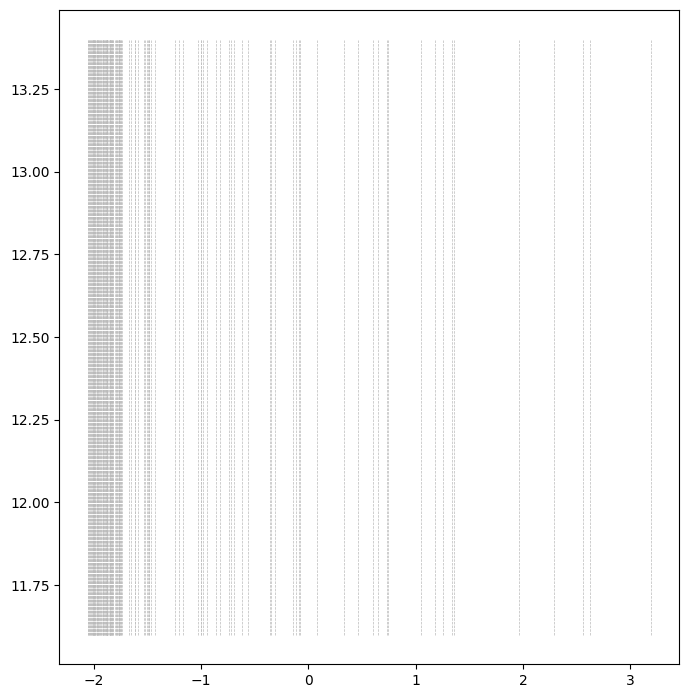

In [73]:
shap.plots.waterfall(shap_vals_waterfall[0][0], max_display=14)

In [ ]:
shap.plots.waterfall(shap_values_16_p_5, max_display=14)

### steps for model 17: compute shap values on 50 samples per cell type

In [44]:
X_train_p_17 = pd.read_pickle('private_X_train_svd_64.pkl')
X_train_p_17 = X_train_p_17.iloc[np.sort(X_train_p_sampled.obs['ID'])]      # use 160 samples per cell type -> even distr.

X_test_p_17 = ad.read_h5ad('private_test_input_64_svd_5_samples.h5ad')

print('X_train: ', X_train_p_17.shape)
print('X_test: ', X_test_p_17.shape)

med = X_train_p_17.median().values.reshape((1,X_train_p_17.shape[1]))
explainer17_p = shap.KernelExplainer(model17, med)

# shap_values_17_p = explainer17_p.shap_values(X_test_p_17.to_df(), nsamples=300)

X_train:  (1120, 148)
X_test:  (35, 148)


In [ ]:
# np.save('shap_values_17_50_samples_p_ct_distr.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)
# np.save('shap_values_17_p_5_properties.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)

In [45]:
shap_values_17_p_5 = np.load('shap_values_17_p_5_properties.npy', allow_pickle=True)

#### check SHAP properties:

#### dummy

In [46]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_17.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_17_p_5_dummy = explainer17_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_17_p_5_properties_set_median_train.npy', np.array(shap_values_17_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_17_p_5_dummy = np.load('shap_values_17_p_5_properties_set_median_train.npy', allow_pickle=True)
pd.DataFrame(shap_values_17_p_5_dummy[127])

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.0,0.129769,-0.135797,-0.009893,-0.015608,0.0,0.0,0.004761,0.0,-0.080656,...,0.010699,-0.011267,0.0,0.018032,0.0,0.014571,0.018159,0.0,0.0,0.0
1,0.0,-0.023373,0.045655,0.0,0.0,0.0,0.005992,-0.000805,-0.003113,0.009712,...,0.0,-0.008965,0.0,0.00376,-0.002778,0.01185,0.004316,0.0,0.005409,0.0
2,0.0,-0.026073,0.041756,-0.006252,-0.00525,-0.003133,0.00882,0.00159,0.010114,-0.029422,...,0.001059,0.0,0.0,0.000718,0.0,0.015844,0.001361,0.0,0.002751,0.0
3,0.001213,-0.01422,0.049424,0.0,0.00328,-0.008128,-0.0059,0.01083,-0.005464,0.0,...,0.000718,0.006119,-0.005634,0.0,0.0,0.013637,-0.033559,-0.001158,0.0,0.0
4,0.0,0.051701,-0.031154,0.0,-0.018027,-0.012227,0.006988,0.0,0.011156,-0.103664,...,0.0,-0.013045,0.0,-0.005444,0.0,0.0,0.007886,0.003621,0.0,0.0
5,0.0,-0.058556,0.027001,-0.014343,-0.004153,-0.006098,0.009811,0.0,-0.008827,0.022314,...,0.001289,-0.012941,-0.001828,-0.000748,0.0,0.013569,0.008123,-0.005922,0.0,0.0
6,0.008653,-0.029146,-0.007111,0.0,-0.155087,0.0,-0.028371,-0.004032,0.002055,0.009049,...,0.008945,0.000764,-0.004606,0.001183,0.0,0.01567,0.002777,0.0,0.0,0.0
7,-0.006853,-0.045218,-0.00161,-0.012904,-0.035781,0.029999,0.009923,0.0,0.0,0.012002,...,0.0,-0.008365,-0.016241,-0.000232,0.0,0.016486,0.005719,-0.002106,0.0,0.0
8,0.009298,0.003827,0.038391,0.0,-0.086368,0.0,0.003719,0.0,-0.003002,0.0,...,0.0,0.0,-0.010019,0.0,-0.007571,0.007782,0.0,0.0,0.010164,0.0
9,0.008561,-0.038519,0.006678,0.018035,-0.154255,0.0,0.016594,0.0,0.001284,0.015176,...,0.0,0.0,0.0,0.0,0.0,0.019757,0.002454,-0.010553,0.0,0.0


#### efficiency

In [47]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 121
cell_idx = 0
shap_v = shap_values_17_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

2.0251983776688576

In [48]:
test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model17, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

  0%|          | 0/1 [00:00<?, ?it/s]

1.9639735

In [49]:
expected = explainer17_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

-0.06122473627328873
1.1920928955078125e-07


True

### ensemble analysis

Combine handselected genes of model 16 and 17 only. \
Weighted sum of the respective shap values. \
Check if these summed ensemble shap values fulfil the shap properties.

In [51]:
weights = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]   # ensemble weights from codebase
weight_sum = np.array(weights).sum()
# models 16 and 17 both have weight 1 -> normalize by weight_sum for this small ensemble of only 16 and 17
weight_16 = 1/2     # 1/2 since only 2? not 1 / weight_sum
weight_17 = 1/2     # 1 / weight_sum

In [52]:
shap_values_16_p_handselected = shap_values_16_p_5[:,:,-84:]

In [53]:
shap_values_17_p_handselected = shap_values_17_p_5[:,:,-84:]

In [54]:
shap_values_ensemble_p_handselected = weight_16 * shap_values_16_p_handselected + weight_17 * shap_values_17_p_handselected

#### dummy

fulfilled since weight_16 * 0 + weight_17 * 0 = 0

In [58]:
shap_values_ensemble_p_dummy = weight_16 * shap_values_16_p_5_dummy[:,:,-84:] + weight_17 * shap_values_17_p_5_dummy[:,:,-84:]
pd.DataFrame(shap_values_ensemble_p_dummy[0])

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,0.0,-0.009866,0.003867,0.0,0.0,0.0,-0.020003,-0.00411,0.0,...,0.0,-0.001905,0.0,-0.014983,0.0,0.0,0.005128,0.0,0.006797,0.0
1,0.0,0.016456,0.0,0.004125,-0.005761,0.0,0.0,-0.005401,0.0,0.0,...,-0.002335,-0.003458,0.0,0.00809,-0.004126,0.006342,-0.000882,0.002094,0.0,0.0
2,0.0,0.009443,0.0,0.008004,0.0,0.0,0.0,-0.003324,0.0,0.0,...,0.000676,0.0,0.0,0.0,0.0,0.000389,-0.002669,0.0,0.003384,0.0
3,0.0,0.011102,0.0,-0.0058,0.0,0.0,0.0,0.002907,-0.005022,0.0,...,0.005755,-0.003502,0.006486,-0.000388,0.0,0.010373,-0.012261,0.0,0.000336,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005923,0.0,-0.005989,...,0.0,-0.005323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.008081,-0.005963,-0.00148,0.011008,0.0,0.0,0.002118,-0.0136,0.0,...,-0.004801,-0.002554,0.001903,0.0,0.0,0.002376,-0.005475,-0.003651,0.0,0.0
6,0.0,0.008595,-0.003107,0.012017,0.0,0.00233,0.0,-0.005609,-0.010444,0.0,...,-0.000688,0.0,-0.000914,0.00807,0.0,0.01603,0.012673,0.000857,0.005796,0.0
7,0.0,0.010256,0.0,0.011372,-0.009051,0.0,0.0,0.0,0.0,0.0,...,0.003605,-0.010734,-0.005763,0.0,0.0,0.00294,0.0,-0.000243,0.005086,0.0
8,0.0,0.0,0.007953,0.001823,0.0,0.0,0.0,0.0,-0.000733,0.0,...,0.0,0.0,0.0,0.0,-0.010288,0.0,-0.004924,0.005853,-0.001903,0.0
9,-0.015726,-0.005611,-0.008036,0.0,0.0,-0.006556,0.0,0.0,-0.014953,0.0,...,-0.008205,-0.005264,0.0,0.0,0.0,0.015527,0.0,0.0,0.008925,0.0


#### efficiency

In [56]:
protein_idx = 121
cell_idx = 0
shap_v_16 = shap_values_16_p_5[:,:,-84:][protein_idx][cell_idx].sum()    # [protein][cell]   # remove [:,:,-84:]?
print(shap_v_16)
shap_v_17 = shap_values_17_p_5[:,:,-84:][protein_idx][cell_idx].sum()    # [protein][cell]
print(shap_v_17)

2.3654727309366357
2.252503777064029


In [57]:
shap_v_ensemble = shap_values_ensemble_p_handselected[protein_idx][cell_idx].sum()
shap_v_ensemble

2.308988254000333

In [58]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16 = test_loop(model16, test_dataloader).astype(np.float32)

test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred17 = test_loop(model17, test_dataloader).astype(np.float32)

pred = weight_16 * pred16 + weight_17 * pred17

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2.220395

In [101]:
expected = explainer16_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - (weight_16 * shap_v_16 - weight_17 * shap_v_17)))
expected == predicted - (weight_16 * shap_v_16 + weight_17 * shap_v_17)

-0.843746542930603
-0.4191410019993782


False

In [103]:
predicted - shap_v_ensemble

-0.22604620405685621

In [72]:
cols84 = []
for col in X_train_p_16.columns:
    if str(col).startswith('imp'):
        cols84.append(col)
X_train_p_handselected = X_train_p_16[cols84]   # == X_train_p_17[cols84]

In [82]:
explainer16_p.expected_value

array([-0.84374654, -1.13664341, -1.0564841 ,  1.34051824,  1.48395491,
        1.38483942,  1.99394798, -1.08629751, -1.02615416, -1.10647082,
       -1.30383444, -1.20256102, -1.22408473, -1.16803741,  3.29594517,
       -0.68833971, -0.46318069, -0.28808582,  0.04834228, -1.0223068 ,
       -1.02358139, -0.11733066, -1.13616359, -1.03883934,  3.36820698,
       -1.15125883, -1.26027679, -1.30996263, -1.15491176, -1.18534982,
       -1.22528052, -1.09715509, -1.26360726, -1.22239351, -1.14253402,
       -1.26778841, -1.03597927,  3.93391037, -1.09592807, -1.14547908,
       -1.29449713, -1.23096764, -1.11304784,  0.62129009, -1.26891589,
       -1.1772716 , -0.9923104 , -1.06520534,  1.7930727 , -1.2410841 ,
       -1.08507359, -1.14002991, -0.7854771 , -1.29014385, -0.7296856 ,
       -0.42497191, -1.13409197,  0.38147539, -1.18809175, -1.22908711,
       -1.14144099, -1.02548683, -1.08903658, -1.17751932, -1.18983674,
       -1.00378454, -1.01291072, -0.93045729, -0.20434535, -1.16

In [83]:
explainer17_p.expected_value

array([-1.08999813, -1.34688365, -1.10532069,  1.30255413,  0.96700305,
        1.71225274,  1.44556367, -1.30534708, -1.1931541 , -1.12956214,
       -1.55995274, -1.22835159, -1.36134481, -1.30034685,  3.23963618,
        0.68152314,  0.29563493, -0.94980264,  0.21309742, -1.38610578,
       -1.21739399,  0.15441036, -1.51836407, -1.12965763,  3.06655049,
       -1.36125338, -1.5188942 , -1.56979835, -1.26131821, -1.34218991,
       -1.26192534, -1.22796535, -1.44110346, -1.39839649, -1.35851407,
       -1.57264841, -1.05596697,  4.14822531, -1.12322116, -1.24631596,
       -1.43466747, -1.29151332, -1.26177502,  0.563308  , -1.6759125 ,
       -1.38005817, -0.93186092, -1.28821588,  1.68641257, -1.36771762,
       -1.22779405, -1.2746799 , -0.97608662, -1.55874288, -0.69806933,
       -0.82289898, -1.24035311,  0.67126989, -1.39220786, -1.1176151 ,
       -1.45161331, -1.26392281, -1.12447679, -1.21555281, -1.46133482,
       -1.05247462, -0.77789038, -1.01714766, -0.25026408, -1.39

In [73]:
med = X_train_p_handselected.median().values.reshape((1,X_train_p_handselected.shape[1]))
explainer17_p = shap.KernelExplainer(model17, med)

Provided model function fails when applied to the provided data set.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x84 and 148x256)

#### consistency